# **Building a Convolutional Neural Network with Keras**

In [ ]:
#Tensorflow version

import tensorflow as tf
print(tf.__version__)

In [ ]:
#Importing libraries

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.applications.efficientnet import EfficientNetB0
from keras.preprocessing import image
#from keras.preprocessing.image import load_img
from keras.models import Sequential
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = os.path.join('directory/training/')
validation_dir = os.path.join('directory/validation/')

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    )

val_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(96,96),
    batch_size=32,
    class_mode='binary',
    )

Found 16413 images belonging to 2 classes.
Found 3320 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([

    # First convolution layer
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolution layer
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Third convolution layer
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    # Fully connected hidden layer
    tf.keras.layers.Dense(96, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#print model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 96, 94, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 47, 32)       0         
 2D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 48, 45, 64)        6208      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 22, 64)       0         
 2D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 20, 128)       24704     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 10, 128)     

In [ ]:
#Performance evaluation Metrics delcaration

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision, AUC

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5), AUC(num_thresholds=200,curve='ROC')])


In [ ]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.99):
            print("\n Reached 99% accuracy so cancelling training!")
            self.model.stop_training=True

mycallback=mycallback()

In [ ]:
#Model Execution

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initializing Device Specification
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")

# Printing the DeviceSpec
print('Device Spec: ', device_spec.to_string())

# Enabling device logging
tf.debugging.set_log_device_placement(True)

# Specifying the device
with tf.device(device_spec):

#with tf.device('/gpu:10'):

    checkpoint = ModelCheckpoint("ECG_Model_Lead_0.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    mycallback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100, mode="auto")

    history = model.fit(
          train_data,
          steps_per_epoch=10,
          epochs=500,
          verbose=1,
          validation_data = val_data,
          validation_steps=5,
          callbacks = [mycallback,checkpoint]
    )

Device Spec:  /job:localhost/replica:0/device:GPU:*
Epoch 1/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.6861 - accuracy: 0.5799 - sensitivity_at_specificity_2: 0.4138 - specificity_at_sensitivity_2: 0.4244 - recall_2: 0.1034 - precision_2: 0.4138 - auc_2: 0.4609
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to ECG_Model_Lead_0.h5
10/10 [==============================] - 4s 242ms/step - loss: 0.6848 - accuracy: 0.5844 - sensitivity_at_specificity_2: 0.4062 - specificity_at_sensitivity_2: 0.4010 - recall_2: 0.0938 - precision_2: 0.4138 - auc_2: 0.4592 - val_loss: 0.6939 - val_accuracy: 0.5625 - val_sensitivity_at_specificity_2: 0.5429 - val_specificity_at_sensitivity_2: 0.5333 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_2: 0.5369
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.6617 - accuracy: 0.6319 - sensitivity_at_specificity_2: 0.4528 - specificity_at_sensitivity_2: 0.4615 - recall_2: 0.0000e+00 - pr

In [ ]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity_6']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity_6']
Validation_Recall=history.history['val_recall_6']
Validation_Precision=history.history['val_precision_6']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",np.max(Training_Accuracy))
print("Validation Accuracy: ",np.max(Validation_Accuracy))
print("Validation Specificity: ",np.max(Validation_Specificity))
print("Validation Sensitivity: ",np.max(Validation_Sensitivity))
print("Validation Recall: ",np.max(Validation_Recall))
print("Validation Precision: ",np.max(Validation_Precision))
print("Validation Loss: ",np.min(Validation_Loss))

Signal Length:  3000
1/1 [==============================] - 0s 128ms/step
predicted_class 1, _ 0.5020126700401306
1/1 [==============================] - 0s 15ms/step
predicted_class 1, _ 0.5572909116744995
1/1 [==============================] - 0s 13ms/step
predicted_class 1, _ 0.5660375356674194
votes for  /home/ubuntu/From_Laptop/12 leads vs 1 lead/lead 0/temp_images/3.png  is:  [1, 1, 1]
sum_confidence_1 1.6253411173820496, sum_confidence_0 0
Overall Label: 1
File: A00473.npy, Actual Label: 0, Predicted Label: 1
Signal Length:  3000
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.2569386959075928
1/1 [==============================] - 0s 14ms/step
predicted_class 0, _ 0.2838497757911682
1/1 [==============================] - 0s 14ms/step
predicted_class 0, _ 0.18019148707389832
votes for  /home/ubuntu/From_Laptop/12 leads vs 1 lead/lead 0/temp_images/3.png  is:  [0, 0, 0]
sum_confidence_1 0, sum_confidence_0 0.7209799587726593
Overall Label: 0
File: A00520

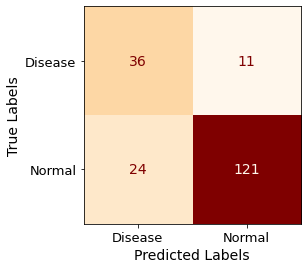

In [ ]:
#Proposed model architecture

from keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tensorflow.keras import layers
import cv2
import shutil
from scipy.signal import butter, filtfilt
#from scipy import signal
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Normalization layer
nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)

def create_image(file_path, save_dir):
    # Load file
    x = np.load(file_path)

    x_size=np.array(x).flatten()
    if len(x_size) <= 6000:
        print(f"Skipping file: {file_path} due to insufficient length.")
        return

    # Resample the signals from 300 Hz to 100 Hz
    original_frequency = 300  # Sampling frequency of original signals (in Hz)
    target_frequency = 100  # Target sampling frequency (in Hz)
    # Calculate the resampling ratio
    resampling_ratio = target_frequency / original_frequency
    # Initialize an empty array to store resampled signals
    resampled_signals = []
    # Resample each signal in the dataset
    for signal_data in x:
        # Perform resampling
        resampled_signal = scipy.signal.resample(signal_data, int(len(signal_data) * resampling_ratio))
        resampled_signals.append(resampled_signal)
    # Convert the list of resampled signals back to a NumPy array
    resampled_signals = np.array(resampled_signals)


    signal = resampled_signals[:]
    signal = np.array(signal).flatten()

    b, a = butter(4, 0.02, btype='high', analog=False)
    filtered_ecg = filtfilt(b, a, signal)
    max_index = np.argmax(np.abs(filtered_ecg[600:len(filtered_ecg)-50]))
    y = filtered_ecg[600:len(filtered_ecg)-50]
    max_amplitude = y[max_index]

    if max_amplitude >= 0:
        signal = signal
    else:
        signal = -(signal)


    # Divide the signal into three parts
    sub_image_length = 1000
    print("Signal Length: ",len(signal))
    for i in range(3):
        start_idx = i * sub_image_length
        end_idx = (i + 1) * sub_image_length

        sub_signal = signal[start_idx:end_idx]
        normalized_array = (sub_signal / max(sub_signal)).clip(-1, 1)

        plt.figure(figsize=(1.25, 1.25))
        plt.plot(normalized_array, 'gray')
        plt.axis("off")

        sub_image_path = os.path.join(save_dir, f"{i + 1}.png")
        plt.savefig(sub_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

def load_image(img_path, target_size=(96, 96)):
    img = image.load_img(img_path, target_size=target_size)

    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)
    img_tensor = nrmzln_layer(img_tensor)

    return img_tensor

def predict_class(model, img_path, threshold=0.44):

    img_tensor = load_image(img_path)
    pred = model.predict(img_tensor)
    return 1 if pred >= threshold else 0, pred[0][0]

def evaluate_test_folder(model, test_folder):
    class_labels = sorted(os.listdir(test_folder))
    total_samples = 0
    correct_predictions = 0
    misclassifications = {0: 0, 1: 0}
    skipped_files = []
    true_labels = []
    predicted_probabilities = []
    confidence_score=[]

    for class_label in class_labels:
        class_path = os.path.join(test_folder, class_label)
        for npy_file in os.listdir(class_path):
            npy_path = os.path.join(class_path, npy_file)

            # Create three sub-images using create_image function
            save_dir = "directory/temp_images"
            create_image(npy_path, save_dir)

            # Predict class label for each sub-image
            votes = []
            votes_avg = []
            for i in range(1, 4):
                sub_image_path = os.path.join(save_dir, f"{i}.png")
                predicted_class, _ = predict_class(model, sub_image_path)
                print(f"predicted_class {predicted_class}, _ {_}")
                votes.append(predicted_class)
                votes_avg.append(_)

            print("votes for ",sub_image_path," is: ",votes)
            # Determine the overall label based on voting
            #overall_label = 1 if votes.count(1) >= 2 else 0


            # Sum up the confidence values for each class
            sum_confidence_1 = sum([conf for vote, conf in zip(votes, votes_avg) if vote == 1])
            sum_confidence_0 = sum([conf for vote, conf in zip(votes, votes_avg) if vote == 0])
            print(f"sum_confidence_1 {sum_confidence_1}, sum_confidence_0 {sum_confidence_0}")
            # Determine the overall label based on voting
            overall_label = 1 if sum_confidence_1 > sum_confidence_0 else 0
            print("Overall Label:", overall_label)

            if sum_confidence_1 > sum_confidence_0:
                confidence_score.append(sum_confidence_1)
            else:
                confidence_score.append(sum_confidence_0)

            # Get true class label based on folder name
            true_class = 0 if class_label == 'disease' else 1

            # Print details for each file
            print(f"File: {npy_file}, Actual Label: {true_class}, Predicted Label: {overall_label}")

            #print("Before:: total samples: ",total_samples, " correct pred ", correct_predictions, " Misc.",misclassifications)
            # Update metrics
            total_samples += 1
            correct_predictions += 1 if overall_label == true_class else 0
            true_labels.append(true_class)
            predicted_probabilities.append(overall_label)

            # Track misclassifications
            if overall_label != true_class:
                misclassifications[true_class] += 1

            #print("After:: total samples: ",total_samples, " correct pred ", correct_predictions, " Misc.",misclassifications)

    print("confidence score: ", confidence_score)
    accuracy = correct_predictions / total_samples
    auc = roc_auc_score(true_labels, predicted_probabilities)

    print("True labels: ",true_labels)
    print("pred labels: ",predicted_probabilities)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")
    print(f"AUC: {auc}")
    print("Misclassifications:")
    for class_label, count in misclassifications.items():
        print(f"Class {class_label}: {count} misclassifications")

    if skipped_files:
        print("\nSkipped Files:")
        for skipped_file in skipped_files:
            print(skipped_file)

                # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_probabilities)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Disease', 'Normal'])
    disp.plot(cmap='OrRd', values_format='d', ax=plt.gca(), colorbar=False)
    #plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # Increase font size for the sample counts inside the matrix
    for text in disp.text_.ravel():
        text.set_fontsize(14)

    # Save the confusion matrix plot
    plt.savefig("directory/confusion_matrix_lead_0.png", dpi=800, bbox_inches='tight')

    # Clean up temporary images
    files = glob.glob(r'directory/temp_images/*')
    for items in files:
        os.remove(items)

# Load the model
model_path = "directory/ECG_Model_Lead_0.h5"
model = load_model(model_path)

# Test folder path
test_folder_path = 'directory/test_set/'

# Evaluate the test folder
evaluate_test_folder(model, test_folder_path)



In [ ]:
#Basic Model (without proposed architecture) test set predictions
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras import layers
import cv2

# Normalization layer
nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)

def load_image(img_path, target_size=(96, 96)):
    img = image.load_img(img_path, target_size=target_size)

    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # Replace normalization with Keras Rescaling layer
    nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)
    img_tensor = nrmzln_layer(img_tensor)

    return img_tensor

def predict_class(model, img_path, threshold=0.20):
    img_tensor = load_image(img_path)
    print(img_tensor.shape)
    pred = model.predict(img_tensor)
    return 1 if pred >= threshold else 0, pred[0][0]

def remove_simple_background(img_tensor, target_size=(96, 96)):
    # Convert the image tensor to a NumPy array
    img_array = np.squeeze(img_tensor, axis=0)

    # Convert to uint8 and ensure 3 channels (assuming RGB image)
    img_array = img_array.astype(np.uint8)
    if img_array.shape[-1] == 1:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Apply a simple threshold to identify the background (assuming it's white)
    _, thresholded = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image
    mask = cv2.bitwise_not(thresholded)

    # Apply the mask to the original image
    result = cv2.bitwise_and(img_array, img_array, mask=mask)

    # Resize the result if needed
    result = cv2.resize(result, target_size)

    # Expand dimensions for compatibility with the original code
    result_tensor = np.expand_dims(result, axis=0)

    return result_tensor

def evaluate_test_folder(model, test_folder):
    class_labels = sorted(os.listdir(test_folder))
    total_samples = 0
    correct_predictions = 0
    misclassifications = {0: 0, 1: 0}

    for class_label in class_labels:
        class_path = os.path.join(test_folder, class_label)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Predict class label using the model
            predicted_class, prediction_value = predict_class(model, image_path)

            # Get true class label based on folder name
            true_class = 0 if class_label == 'disease' else 1

            # Print details for each image
            print(f"Image: {image_file}, Actual Label: {true_class}, Predicted Label: {predicted_class}, Prediction Value: {prediction_value}")

            # Update metrics
            total_samples += 1
            correct_predictions += 1 if predicted_class == true_class else 0

                        # Track misclassifications
            if predicted_class != true_class:
                misclassifications[true_class] += 1

    accuracy = correct_predictions / total_samples
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")
    print("misclassifications")
    for class_label, count in misclassifications.items():
        print(f"Class {class_label}: {count} misclassifications")

# Load the model
model_path = "directory/ECG_Model_Lead_0.h5"

test_folder_path = 'directory/test_set/'


# Evaluate the test folder
evaluate_test_folder(model, test_folder_path)


(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00004.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.12942178547382355
(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00225.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.17838571965694427
(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00216.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.13582220673561096
(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00267.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.14563500881195068
(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00009.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.15369027853012085
(1, 96, 96, 3)
1/1 [==============================] - 0s 14ms/step
Image: A00231.png, Actual Label: 0, Predicted Label: 0, Prediction Value: 0.195478156208992
(1, 96, 96, 3)
1/1 [================